In [1]:
#@title Install Dependencies (restart session after complete: Runtime > Restart Session)
## Instructions:
## 1. Run this cell to force uninstall existing numpy version
## 2. Restart Runtime (Menu bar > Runtime > Restart Session)
## 3. Run this cell again to install required numpy version (1.26.4)

!pip install numpy==1.26.4 --force-reinstall
!pip install scanpy SEACells
!pip install -q git+https://github.com/theislab/cellrank

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
#@title Import Required Libraries
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData

import cellrank as cr
import scvelo as scv
import SEACells

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import nnls
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
from scipy.sparse import hstack

%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
#@title Define Methods to Run Pipeline (for both Approach 1 and Approach 2)
def combine_spliced_unspliced_for_SEACells(adata):
    """
    Combines spliced and unspliced layers from an AnnData object to create a new
    AnnData object suitable for SEACells analysis.

    This function adds the spliced and unspliced RNA counts (from `adata.layers["spliced"]`
    and `adata.layers["unspliced"]`) to form a combined count matrix. It creates a new
    AnnData object using this matrix and copies over relevant metadata.

    Parameters:
    -----------
    adata : AnnData
        An AnnData object containing spliced and unspliced count matrices
        in the `.layers` attribute.

    Returns:
    --------
    adata_combined : AnnData
        A new AnnData object with combined counts as the primary data matrix (`.X`)
        and stored again in `.layers["combined"]`. Metadata (`obs`, `var`, `uns`, etc.)
        is copied from the original AnnData object.
    """
    combined_counts = adata.layers["spliced"] + adata.layers["unspliced"]
    adata_combined = AnnData(X=combined_counts)
    adata_combined.obs = adata.obs.copy()
    adata_combined.var = adata.var.copy()
    adata_combined.uns = adata.uns.copy()

    # Add Metadata
    if hasattr(adata, "obsp"):
        adata_combined.obsp = adata.obsp.copy()
    if hasattr(adata, "varp"):
        adata_combined.varp = adata.varp.copy()

    adata_combined.layers["combined"] = combined_counts
    return adata_combined

def preprocess_for_SEACells(adata, normalize=True, log_transform=True, n_top_genes=2000, use_highly_variable=False, n_pcs=30, n_neighbors=30, random_state=0, ):
    """
    Preprocesses an AnnData object for use with SEACells by performing standard
    single-cell RNA-seq data processing steps.

    Parameters:
    -----------
    adata : AnnData
        The annotated data matrix (cells x genes) to be processed.
    normalize : bool, default=True
        Whether to normalize counts per cell to a target sum (1e4).
    log_transform : bool, default=True
        Whether to apply log1p transformation to normalized data.
    n_top_genes : int, default=2000
        Number of top highly variable genes to select (used only if use_highly_variable=True).
    use_highly_variable : bool, default=False
        Whether to subset the data to the top highly variable genes.
    n_pcs : int, default=30
        Number of principal components to compute and use for neighborhood graph construction.
    n_neighbors : int, default=30
        Number of nearest neighbors for computing the neighborhood graph.
    random_state : int, default=0
        Seed for reproducibility in PCA and UMAP.

    Returns:
    --------
    adata : AnnData
        The processed AnnData object with PCA, neighbors, and UMAP embeddings computed.
    """
    if normalize:
        sc.pp.normalize_total(adata, target_sum=1e4)

    if log_transform:
        sc.pp.log1p(adata)

    if use_highly_variable:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
        adata = adata[:, adata.var.highly_variable]

    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=n_neighbors, random_state=random_state)
    sc.tl.umap(adata, random_state=random_state)

    return adata

def run_SEACells(adata, n_SEACells, build_kernel_on, n_waypoint_eigs, convergence_epsilon, min_iter, max_iter):
    """
    Runs the SEACells algorithm on a preprocessed AnnData object to identify metacells
    (SEACells) that represent underlying cellular states.

    Parameters:
    -----------
    adata : AnnData
        Preprocessed AnnData object containing single-cell data. Should be PCA-transformed
        and have a neighborhood graph computed.
    n_SEACells : int
        The number of SEACells (metacells) to identify.
    build_kernel_on : str
        The attribute of `adata.obsm` on which to construct the kernel (e.g., 'X_pca' or 'X_umap').
    n_waypoint_eigs : int
        Number of eigenvectors to use when constructing waypoints.
    convergence_epsilon : float
        Threshold for convergence; lower values require tighter convergence of the model.
    min_iter : int
        Minimum number of iterations to run the SEACells optimization.
    max_iter : int
        Maximum number of iterations to run the SEACells optimization.

    Returns:
    --------
    model : SEACells.core.SEACells
        A fitted SEACells model object containing the archetype assignments and kernel matrix.
    """
    model = SEACells.core.SEACells(adata,
                      build_kernel_on=build_kernel_on,
                      n_SEACells=n_SEACells,
                      n_waypoint_eigs=n_waypoint_eigs,
                      convergence_epsilon = convergence_epsilon)
    model.construct_kernel_matrix()
    M = model.kernel_matrix
    model.initialize_archetypes()
    SEACells.plot.plot_initialization(adata, model) # Plot the initilization to ensure they are spread across phenotypic space
    model.fit(min_iter=min_iter, max_iter=max_iter)
    return model

def get_encoded(model):
    """
    Extracts the soft assignment matrix from a fitted SEACells model and encodes it as a
    DataFrame where each row corresponds to a cell and each column to a SEACell (metacell).

    The resulting DataFrame contains soft assignment weights indicating the contribution
    of each SEACell to each cell. A one-hot encoding is initially constructed based on the
    top-k SEACell contributors, then updated with the actual soft assignment weights.

    Parameters:
    -----------
    model : SEACells.core.SEACells
        A fitted SEACells model from which to extract cell-to-metacell soft assignments.

    Returns:
    --------
    encoded : pandas.DataFrame
        A DataFrame of shape (n_cells, n_SEACells) with soft assignment weights, where
        each entry indicates the contribution of a SEACell to a given cell.
    """
    labels, weights = model.get_soft_assignments()
    unique_vals = pd.unique(labels.values.ravel())

    # Create a new DataFrame with same index and unique values as columns
    encoded = pd.DataFrame(0, index=labels.index, columns=unique_vals)

    # Fill in 1 where values match
    for col in labels.columns:
        encoded.values[range(len(labels)), labels[col].map({v: i for i, v in enumerate(unique_vals)})] = 1

    for i, index in enumerate(labels.index): # i = cell name, index = cell index
      curr_cell = labels.loc[index] # the top 5 metacells contributors for a given cell
      for j, soft_assign in enumerate(curr_cell): # j = metacell_name, soft_assign = metacell_index
        encoded.loc[index, soft_assign] = weights[i,j]

    return encoded

def get_normalized(df):
    """
    Normalize dataframe so that each row sums to 1.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame to be normalized.

    Returns:
    --------
    pandas.DataFrame
        Normalized DataFrame where each row sums to 1.
    """
    return df.div(df.sum(axis=1), axis=0) # normalize so rowsum = 1


def get_spliced_unspliced(adata):
    """
    Extracts the spliced and unspliced count matrices from an AnnData object
    and returns them as sorted pandas DataFrames.

    This function assumes that the spliced and unspliced counts are stored in
    the `.layers` attribute of the AnnData object. The resulting DataFrames are
    indexed by cell names and have gene names as columns. Rows are sorted by
    cell names to ensure consistent ordering.

    Parameters:
    -----------
    adata : AnnData
        An AnnData object containing spliced and unspliced layers (usually from RNA velocity preprocessing).

    Returns:
    --------
    spliced_df : pandas.DataFrame
        A DataFrame of spliced counts (cells x genes), sorted by cell names.
    unspliced_df : pandas.DataFrame
        A DataFrame of unspliced counts (cells x genes), sorted by cell names.
    """
    spliced = adata.layers['spliced']
    unspliced = adata.layers['unspliced']

    spliced_df = pd.DataFrame(
        spliced.toarray(),
        index=adata.obs_names,
        columns=adata.var_names
    )
    spliced_df = spliced_df.loc[sorted(spliced_df.index)]

    unspliced_df = pd.DataFrame(
        unspliced.toarray(),
        index=adata.obs_names,
        columns=adata.var_names
    )
    unspliced_df = unspliced_df.loc[sorted(unspliced_df.index)]

    return spliced_df, unspliced_df

def get_nnls(A_df, P_df):
    """
    Solves a series of non-negative least squares (NNLS) problems to approximate
    each column of matrix P as a non-negative linear combination of columns in matrix A.

    This is useful for decomposing signals (e.g., expression profiles) into
    basis components with non-negativity constraints.

    Parameters:
    -----------
    A_df : pandas.DataFrame
        Basis matrix (genes x metacells or features), where columns represent basis vectors.
    P_df : pandas.DataFrame
        Target matrix (genes x samples or cells), where each column is a target vector to decompose.

    Returns:
    --------
    S_df : pandas.DataFrame
        Coefficient matrix (metacells/features x samples/cells) where each entry represents
        the non-negative contribution of a basis vector (column of A_df) to reconstruct
        a target column in P_df.
    """
    # Convert inputs to numpy arrays once
    A = A_df.values
    P = P_df.values

    # Preallocate numpy array
    S = np.zeros((A.shape[1], P.shape[1]))

    # Loop over columns
    for j in range(P.shape[1]):
        sol, _ = nnls(A, P[:, j])
        S[:, j] = sol

        if j % 10 == 0:
            print(f"Solved {j}/{P.shape[1]} targets")

    # After solving, convert S back to a DataFrame
    S_df = pd.DataFrame(S, index=A_df.columns, columns=P_df.columns)
    return S_df


def combine_SEACells(spliced_df, unspliced_df):
    """
    Combines spliced and unspliced count DataFrames into a single AnnData object
    from prior SEACells analysis.

    The resulting AnnData object contains:
      - `.X` with combined counts (spliced + unspliced)
      - `.layers['spliced']` with spliced counts
      - `.layers['unspliced']` with unspliced counts

    Parameters:
    -----------
    spliced_df : pandas.DataFrame
        DataFrame of spliced counts (cells x genes), indexed by cell names and with gene names as columns.
    unspliced_df : pandas.DataFrame
        DataFrame of unspliced counts (cells x genes), same shape and indexing as `spliced_df`.

    Returns:
    --------
    adata : AnnData
        An AnnData object containing the combined, spliced, and unspliced counts,
        suitable for downstream preprocessing and analysis.
    """
    combined_counts = spliced_df + unspliced_df

    adata = AnnData(X=combined_counts.values)
    adata.obs_names = spliced_df.index
    adata.var_names = spliced_df.columns

    adata.layers["spliced"] = spliced_df.values
    adata.layers["unspliced"] = unspliced_df.values

    return adata


def run_cellrank(SEACell_combined, n_pcs, n_neighbors, filter=False):
    """
    Runs RNA velocity and computes CellRank transition matrices using a combination
    of VelocityKernel and ConnectivityKernel on SEACell-level data.

    This function optionally filters and normalizes the data, recovers gene dynamics,
    computes velocities, and then constructs a transition matrix that integrates
    both velocity-derived and graph-based cell transitions.

    Parameters:
    -----------
    SEACell_combined : AnnData
        An AnnData object containing combined (spliced + unspliced) SEACell data,
        with spliced and unspliced counts in `.layers`.
    n_pcs : int
        Number of principal components (PCs) to use in the preprocessing pipeline.
        (Note: This argument is not currently used inside the function but may be
        relevant for prior steps.)
    n_neighbors : int
        Number of neighbors to use when building the connectivity graph.
        (Note: This argument is not used in this function but may be relevant if
        neighborhood graphs are recomputed externally.)
    filter : bool, optional (default: False)
        If True, applies `scv.pp.filter_and_normalize` to the data before
        velocity computation.

    Returns:
    --------
    combined_kernel : cellrank.kernels.CompoundKernel
        A CellRank kernel that combines the VelocityKernel and ConnectivityKernel
        with weights 0.8 and 0.2 respectively.
    vk : cellrank.kernels.VelocityKernel
        The velocity kernel computed from RNA velocity.
    ck : cellrank.kernels.ConnectivityKernel
        The connectivity kernel based on neighborhood graph structure.
    """
    if filter:
        scv.pp.filter_and_normalize(
            SEACell_combined,
            min_shared_counts=20,
            n_top_genes=2000,
            subset_highly_variable=False
        )

    scv.tl.recover_dynamics(SEACell_combined, n_jobs=8)
    scv.tl.velocity(SEACell_combined, mode="dynamical")

    vk = cr.kernels.VelocityKernel(SEACell_combined)
    vk.compute_transition_matrix()

    ck = cr.kernels.ConnectivityKernel(SEACell_combined)
    ck.compute_transition_matrix()

    combined_kernel = 0.8 * vk + 0.2 * ck
    return combined_kernel, vk, ck

def visualize_trajectory(SEACell_combined, vk, color, density, number_cells=50):
    """
    Computes UMAP embedding and visualizes RNA velocity trajectories
    on SEACell data using the VelocityKernel.

    This function performs PCA and neighborhood graph construction
    based on the 'spliced' layer, followed by UMAP projection.
    It then overlays the RNA velocity vectors onto the UMAP using
    `velocityKernel.plot_projection`.

    Parameters:
    -----------
    SEACell_combined : AnnData
        AnnData object containing SEACell-level combined data with a 'spliced' layer.
    vk : cellrank.kernels.VelocityKernel
        A precomputed VelocityKernel object from CellRank.
    color : str
        Column name in `SEACell_combined.obs` to use for coloring cells in the plot.
    density : float
        Controls the density of velocity streamlines in the plot.
    """
    sc.pp.pca(SEACell_combined, layer='spliced')
    sc.pp.neighbors(SEACell_combined, use_rep='X_pca')
    sc.tl.umap(SEACell_combined)
    vk.plot_projection(color=color, density=density, size=5000)

def assign_metacell_cluster_labels(combined_contribution, adata, cluster_key='clusters'):
    """
    Assigns cluster labels from the original single-cell AnnData object
    to the SEACell-level metacell representation based on index matching.

    This is useful for comparing metacell assignments to existing cell-type
    annotations or clusters.

    Parameters:
    -----------
    combined_contribution : AnnData
        AnnData object whose `.obs_names` are aligned with a subset of the original adata.
    adata : AnnData
        The original single-cell AnnData object containing cluster labels in `.obs`.
    cluster_key : str, optional (default: 'clusters')
        The column in `adata.obs` that holds cluster or cell-type labels.

    Returns:
    --------
    pandas.Series
        A Series of cluster labels aligned to `combined_contribution.obs_names`.
    """
    return adata.obs.loc[combined_contribution.obs_names, cluster_key]


# Combines spliced and unspliced into a single layer
def concat_spliced_unspliced_for_SEACells(adata):
    """
    Assigns cluster labels from the original single-cell AnnData object
    to the SEACell-level metacell representation based on index matching.

    This is useful for comparing metacell assignments to existing cell-type
    annotations or clusters.

    Parameters:
    -----------
    combined_contribution : AnnData
        AnnData object whose `.obs_names` are aligned with a subset of the original adata.
    adata : AnnData
        The original single-cell AnnData object containing cluster labels in `.obs`.
    cluster_key : str, optional (default: 'clusters')
        The column in `adata.obs` that holds cluster or cell-type labels.

    Returns:
    --------
    pandas.Series
        A Series of cluster labels aligned to `combined_contribution.obs_names`.
    """
    concatenated_counts = hstack([adata.layers['spliced'], adata.layers['unspliced']])

    # 2. Prepare updated gene names (var)
    var_spliced = adata.var.copy()
    var_unspliced = adata.var.copy()

    var_spliced.index = var_spliced.index + "_spliced"
    var_unspliced.index = var_unspliced.index + "_unspliced"

    var_combined = pd.concat([var_spliced, var_unspliced], axis=0)

    # 3. Create a new AnnData object
    adata_combined = AnnData(X=concatenated_counts)

    # 4. Transfer obs and new var
    adata_combined.obs = adata.obs.copy()
    adata_combined.var = var_combined
    adata_combined.raw = adata_combined.copy()

    return adata_combined


def restack_layers(concatenated_metacell_adata, adata):
    """
    Reconstructs an AnnData object with separated 'spliced' and 'unspliced' layers
    from a concatenated input where spliced and unspliced data were stacked side-by-side.

    Parameters:
    -----------
    concatenated_metacell_adata : AnnData
        AnnData object where the count matrix X has spliced and unspliced counts concatenated horizontally.
        Shape: (n_cells, n_genes * 2)

    adata : AnnData
        A reference AnnData object (e.g. the original before concatenation) to restore variable metadata.

    Returns:
    --------
    new_adata : AnnData
        A new AnnData object with `X` as the combined (spliced + unspliced) counts and
        `.layers["spliced"]`, `.layers["unspliced"]` appropriately restored.
    """


    concatenated_counts = concatenated_metacell_adata.X

    n_spliced = int(concatenated_counts.shape[1] / 2)
    spliced = concatenated_counts[:, :n_spliced]
    unspliced = concatenated_counts[:, n_spliced:]


    combined_counts = spliced + unspliced
    new_adata = AnnData(X=combined_counts)
    new_adata.layers["spliced"] = spliced
    new_adata.layers["unspliced"] = unspliced
    new_adata.obs = concatenated_metacell_adata.obs.copy()
    new_adata.var = adata.var.copy()

    return new_adata


In [4]:
#@title Load Dataset
# Load pancreas dataset
adata = scv.datasets.pancreas()

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

In [5]:
#@title Define Approach 1 Parameters
# Sea Cells Paramaters
n_SEACells = 100
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells. This would be replaced by 'X_svd' for ATAC data.
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
convergence_epsilon = 1e-5 # Convergence threshold
min_iter = 10 # SEACells minimum iteratons for convergence
max_iter = 500 # SEACells maximum iteratons for convergence
minimum_weight = 0.05 # SEACells weight for soft assignments
celltype_label = None # Can optionally provide celltypes for metacells

# Cell Rank parameters
n_pcs = 50 # number of principal componenets for cell rank
n_neighbors = 20 # number of nearest neighbors for KNN graph in cell rank


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x781356ec89a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/3696 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/3696 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/3696 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 93 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 17/17 [00:00<00:00, 190.33it/s]

Selecting 7 cells from greedy initialization.


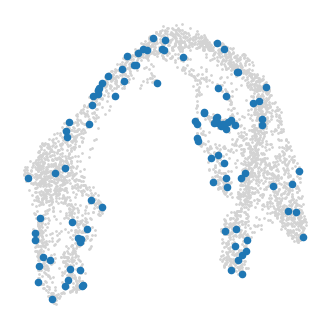

NNLS CompletedFiltered out 23116 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
Logarithmized X.
recovering dynamics (using 2/2 cores)


/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


  0%|          | 0/4882 [00:00<?, ?gene/s]

    finished (0:05:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


/usr/local/lib/python3.11/dist-packages/scvelo/tools/velocity.py:326: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  moments(adata)
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


  0%|          | 0/100 [00:00<?, ?cell/s]

  0%|          | 0/100 [00:00<?, ?cell/s]

/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


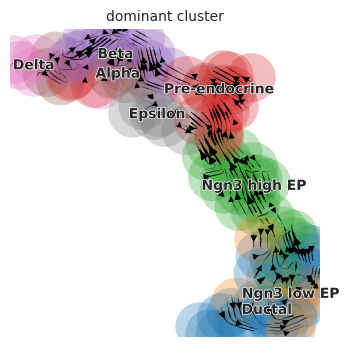

In [6]:
#@title Run Approach 1 Pipeline With Specified Parameters

# Run SEACells
combined = combine_spliced_unspliced_for_SEACells(adata)
combined = preprocess_for_SEACells(combined)
model = run_SEACells(combined, n_SEACells, build_kernel_on, n_waypoint_eigs, convergence_epsilon, min_iter, max_iter)

# Run nnls
encoded = get_encoded(model)
A = get_normalized(encoded)
spliced_df, unspliced_df = get_spliced_unspliced(adata)
M_spliced = get_nnls(A, spliced_df)
M_unspliced = get_nnls(A, unspliced_df)

# Run Cell Rank
metacell_combined = combine_SEACells(M_spliced, M_unspliced)
combined_kernel, vk, ck = run_cellrank(metacell_combined, n_pcs, n_neighbors, filter=True) # combined_kernel is a string formula
metacell_combined.obs['dominant_cluster'] = assign_metacell_cluster_labels(metacell_combined, adata)
visualize_trajectory(metacell_combined, vk, 'dominant_cluster', density=3)

In [7]:
#@title Define Approach 2 Parameters
# Sea Cells Paramaters
n_SEACells = 100
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells. This would be replaced by 'X_svd' for ATAC data.
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
convergence_epsilon = 1e-5 # Convergence threshold
min_iter = 10 # SEACells minimum iteratons for convergence
max_iter = 500 # SEACells maximum iteratons for convergence
minimum_weight = 0.05 # SEACells weight for soft assignments
celltype_label = None # Can optionally provide celltypes for metacells

# Cell Rank parameters
n_pcs = 50 # number of principal componenets for cell rank
n_neighbors = 10 # number of nearest neighbors for KNN graph in cell rank

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/3696 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/3696 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/3696 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 95 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 15/15 [00:00<00:00, 210.08it/s]

Selecting 5 cells from greedy initialization.


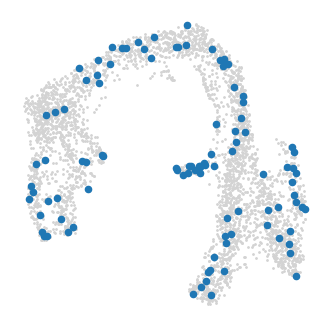

Randomly initialized A matrix.
Setting convergence threshold at 0.00105
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 43 iterations.


100%|██████████| 100/100 [04:04<00:00,  2.44s/it]


Filtered out 22700 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
Logarithmized X.
recovering dynamics (using 2/2 cores)


/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


  0%|          | 0/5298 [00:00<?, ?gene/s]

    finished (0:06:08) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


/usr/local/lib/python3.11/dist-packages/scvelo/tools/velocity.py:326: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  moments(adata)
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


  0%|          | 0/100 [00:00<?, ?cell/s]

  0%|          | 0/100 [00:00<?, ?cell/s]

/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and wi

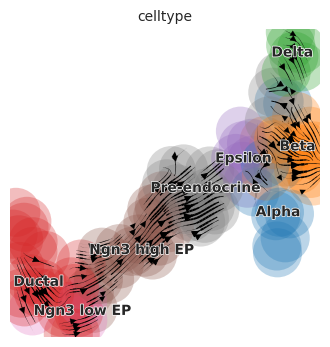

In [8]:
#@title Run Approach 2 Pipeline With Specified Parameters

# Run SEACells
concatenated = concat_spliced_unspliced_for_SEACells(adata)
concatenated = preprocess_for_SEACells(concatenated)
model = run_SEACells(concatenated, n_SEACells, build_kernel_on, n_waypoint_eigs, convergence_epsilon, min_iter, max_iter)

# Get SEACell gene expression and split matrix back into two layers
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(concatenated, model.A_, celltype_label='clusters',summarize_layer='raw', minimum_weight=0.05)
metacell_combined = restack_layers(SEACell_soft_ad, adata)

# Run Cell Rank
combined_kernel, vk, ck = run_cellrank(metacell_combined, n_pcs, n_neighbors, filter=True) # combined_kernel is a string formula
visualize_trajectory(metacell_combined, vk, 'celltype', density=3)